<a href="https://colab.research.google.com/github/Szymonnnn/predykcja-meczow/blob/main/Programowanie_genetyczne_deap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import bibliotek

In [ ]:
!pip install deap
!pip install networkx
!pip install -q condacolab

In [ ]:
import condacolab
condacolab.install()
!conda install pygraphviz

In [ ]:
from deap import gp, creator, base, tools, algorithms
import operator
import random
import math

Import danych

In [ ]:
import pandas as pd
df = pd.read_csv('Food_for_NN.csv',  encoding= 'unicode_escape')
data = df[['1', '0', '2', '10', '2.1', '12', 'Remisy', 'WygraneL', 'WygraneR', 'Ilosc_zagranych', 'Forma_L', 'Forma_R', 'Tabela_L', 'Tabela_R', 'Pkt_tabela_L', 'Pkt_tabela_R', 'LastWygrL', 'LastWygrR', 'wygraneL', 'wygraneR', 'wynik']]

X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

X = X.values.tolist()
y = y.values.tolist()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.30,
    random_state=1234
)

Dodanie prymitywów - zbioru funkcji z których będzie budowane drzewo

In [ ]:
def _div(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", len(X[0]))
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(_div, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

Zmiana nazwy argumentów

In [ ]:
pset.renameArguments(ARG0='w1')
pset.renameArguments(ARG1='w0')
pset.renameArguments(ARG2='w2')
pset.renameArguments(ARG3='w10')
pset.renameArguments(ARG4='w02')
pset.renameArguments(ARG5='w12')
pset.renameArguments(ARG6='Remisy')
pset.renameArguments(ARG7='WygraneL')
pset.renameArguments(ARG8='WygraneR')
pset.renameArguments(ARG9='Ilosc_zagranych')
pset.renameArguments(ARG10='Forma_L')
pset.renameArguments(ARG11='Forma_R')
pset.renameArguments(ARG12='Tabela_L')
pset.renameArguments(ARG13='Tabela_R')
pset.renameArguments(ARG14='Pkt_tabela_L')
pset.renameArguments(ARG15='Pkt_tabela_R')
pset.renameArguments(ARG16='LastWygrL')
pset.renameArguments(ARG17='LastWygrR')
pset.renameArguments(ARG18='wygraneL')
pset.renameArguments(ARG19='wygraneR')

Stworzenie środowiska do ewolucji

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [ ]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=6, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def evalFunc(X, y, individual):
    func = toolbox.compile(expr=individual)

    sum_loss = 0

    for i in range(len(y)):
        x=X[i]
        out = func(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19])-y[i]
        sum_loss += abs(out)

    avg_loss = sum_loss/len(y)
    return avg_loss, pow(avg_loss, 2)


toolbox.register("evaluate", evalFunc, X_train, y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Statystyki do zebrania

In [ ]:
import numpy
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

Ewolucja

In [ ]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(10)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 80, stats=mstats, halloffame=hof, verbose=True)

In [ ]:
min_ = log.chapters["fitness"].select("min")
gen_ = log.chapters["fitness"].select("gen")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
plt.plot(gen_, min_, "-r", label="Zbiór uczący")
plt.legend(loc="upper right")
plt.xlabel('Pokolenia')
plt.ylabel('Najlepsza wartość fitness')
plt.savefig("wykres.png")

Rysowanie drzewa

10


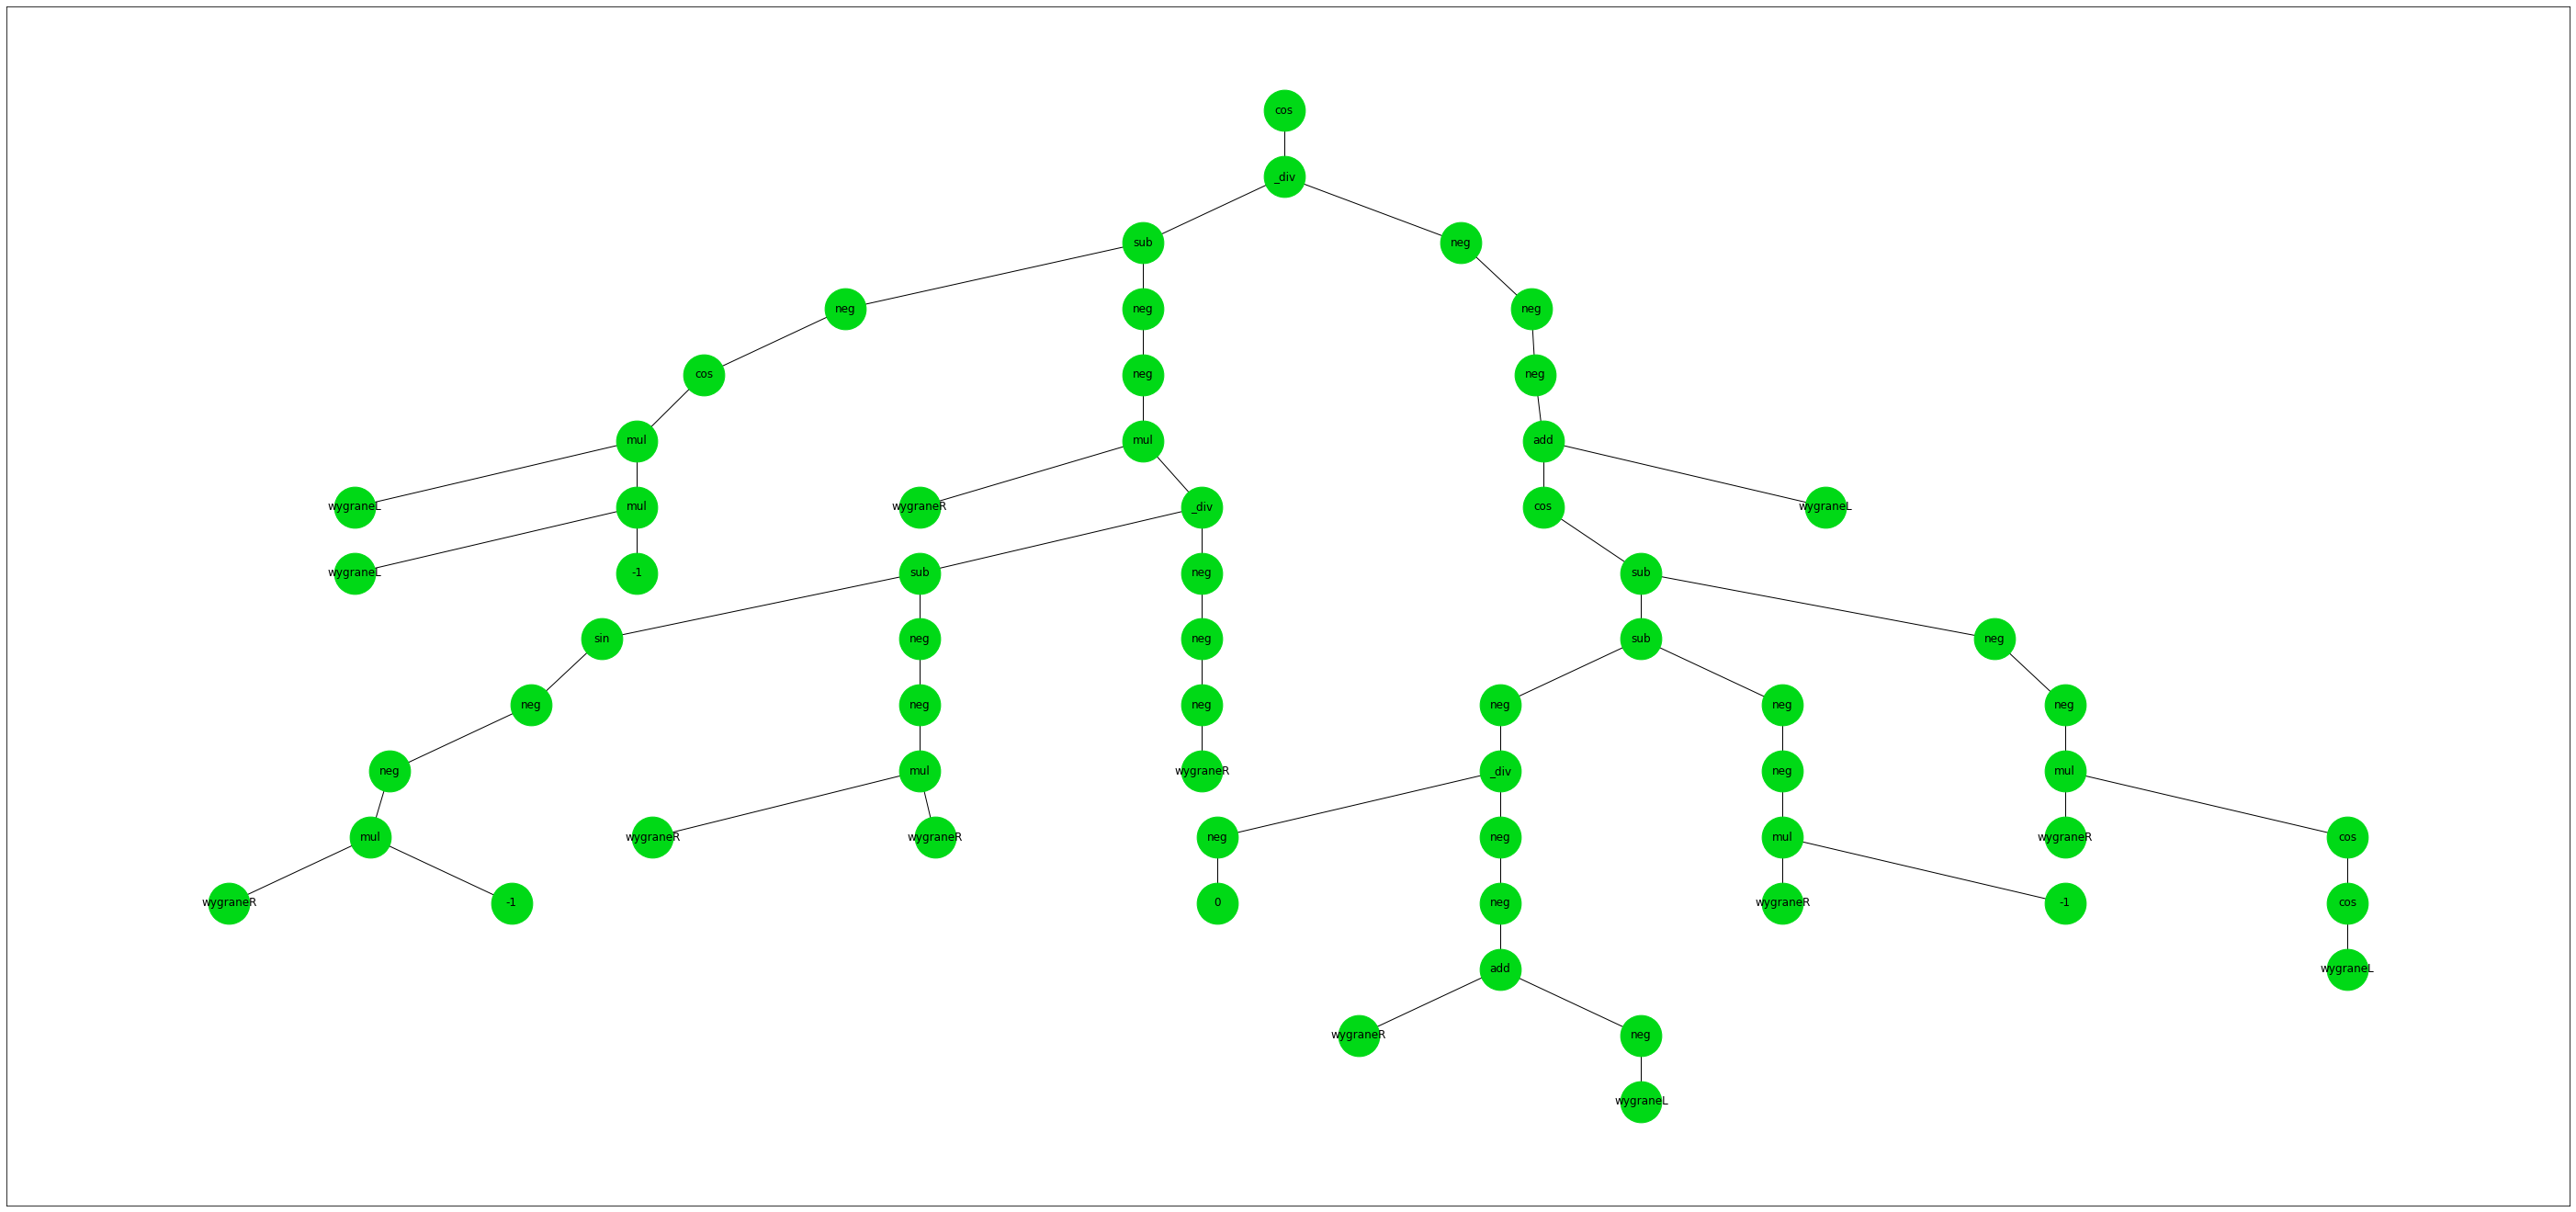

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
print(len(hof))

nodes, edges, labels = gp.graph(hof[0])
plt.rcParams["figure.figsize"] = (50,24)
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)


pos = graphviz_layout(g, prog="dot")
nx.draw_networkx_nodes(g, pos, node_size=2000, node_color='#00d916')
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)

plt.plot(figsize=(8, 6), dpi=80)
plt.savefig("drzewo.png")

Sprawdzenie wyniku 10 najlepszych drzew dla pierwszego meczu w całym zbiorze

In [ ]:
mean = 0
for i in range(len(hof)):
    func = toolbox.compile(expr=hof[0])
    x=X[0]
    f = func(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19])
    mean += f
    print(f)
mean = mean/len(hof)
print()
print(mean)

Stworzenie wektora predykcji

In [ ]:
predict = []
func = toolbox.compile(expr=hof[4])

for i in range(len(y_test)):
    x = X_test[i]
    predict.append(func(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19]))

Wyliczenie błędu średniokwadratowego

In [ ]:
err = 0
for i in range(len(y_test)):
    err += pow(predict[i]-y_test[i], 2)
err = err/len(y_test)
print("MSE: ", round(err, 3))

MSE:  0.094


Progi decyzyjne:

(-inf, -0.5] : -1

(-0.5, 0.5]  :  0

(0.5, inf)   :  1

In [ ]:
choices = []
for i in range(len(y_test)):
    if predict[i]>0.5:
        choices.append(1)
    elif predict[i]>-0.5:
        choices.append(0)
    else:
        choices.append(-1)

Właściwie przewidziane wyniki / wszystkie wyniki

In [ ]:
scores = 0
for i in range(len(y_test)):
    if choices[i] == y_test[i]:
        scores += 1

accuracy_score = scores/len(y_test)
print(accuracy_score)

0.9384372533543804


Funkcja zapisu modelu do pliku i funkcja jego pobrania z pliku

In [ ]:
import dill as pickle
def store_model(model_class, path, verbose = True):
    
    f = open(path, "wb")
    pickle.dump(model_class, f)
    f.close()
    
    if verbose:
        print("Stored the model info!")
    

def load_model(path, verbose = True):

    
    f = open(path, "rb")
    unpickled_model = pickle.load(f)
    f.close()

    return unpickled_model

Zapis modelu do pliku

In [ ]:
store_model(func, "model")

Stored the model info!


Wczytanie modelu z pliku i predykcja pierwszego meczu w całym zbiorze

In [ ]:
model = load_model("model")
x = X[0]
print(model(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19]))

Zapisywanie danych zbioru testowego i predykcji dala niego do pliku csv

In [ ]:
import csv

with open('file.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    writer.writerow(['y_test', 'choice', 'predict', 'w1', 'w0', 'w2', 'w10', 'w02', 'w12', 'Remisy', 'WygraneL', 'WygraneR', 'Ilosc_zagranych', 'Forma_L', 'Forma_R', 'Tabela_L', 'Tabela_R', 'Pkt_tabela_L', 'Pkt_tabela_R', 'LastWygrL', 'LastWygrR', 'wygraneL', 'wygraneR'])
    for i in range(len(y_test)):
        x = X_test[i]
        writer.writerow([y_test[i], choices[i], predict[i], x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19]])


In [ ]:
for i in range(len(y_test)):
    print(y_test[i], "   ",choices[i],"   ", predict[i], "   ", X_test[i])

Urzywane do usuwania zmiennych z pamięci

In [ ]:
exit()